<a href="https://colab.research.google.com/github/cheiz122/stockprice/blob/main/stock_price_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed


Epoch 1/100
32/32 [==============================] - 20s 382ms/step - loss: 0.0300 - val_loss: 0.0010
Epoch 2/100
32/32 [==============================] - 11s 342ms/step - loss: 0.0103 - val_loss: 0.0016
Epoch 3/100
32/32 [==============================] - 11s 335ms/step - loss: 0.0108 - val_loss: 0.0021
Epoch 4/100
32/32 [==============================] - 10s 310ms/step - loss: 0.0100 - val_loss: 8.1081e-04
Epoch 5/100
32/32 [==============================] - 11s 353ms/step - loss: 0.0080 - val_loss: 7.5584e-04
Epoch 6/100
32/32 [==============================] - 11s 343ms/step - loss: 0.0076 - val_loss: 9.8716e-04
Epoch 7/100
32/32 [==============================] - 11s 348ms/step - loss: 0.0077 - val_loss: 9.6108e-04
Epoch 8/100
32/32 [==============================] - 11s 357ms/step - loss: 0.0075 - val_loss: 0.0042
Epoch 9/100
32/32 [==============================] - 11s 343ms/step - loss: 0.0070 - val_loss: 0.0011
Epoch 10/100
32/32 [==============================] - 11s 344ms/st

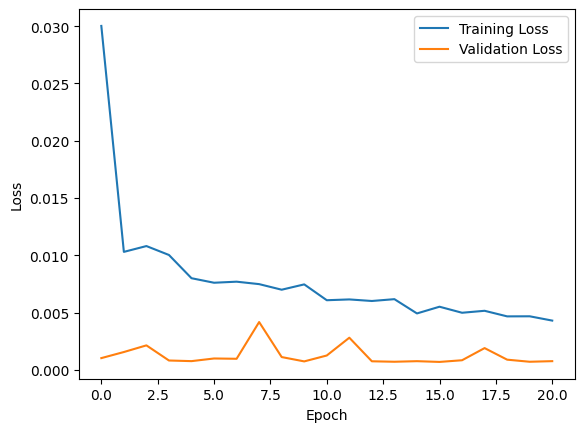

18/18 [==============================] - 2s 113ms/step - loss: 7.4753e-04
Training Mean Squared Error: 0.0007277957629412413
Testing Mean Squared Error: 0.0007475258316844702


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import yfinance as yf

# Download stock data
start_date = "2010-01-01"
end_date = "2024-01-01"
df = yf.download("META", start=start_date, end=end_date)
df = df.reset_index()

# Data preprocessing
def preprocess_data(df):
    scaler = MinMaxScaler(feature_range=(0, 1))
    df['Close_scaled'] = scaler.fit_transform(df['Close'].values.reshape(-1,1))
    return df, scaler

def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(seq_length, len(data)):
        sequences.append(data[i - seq_length:i, :])
        labels.append(data[i, 0])
    return np.array(sequences), np.array(labels)

def feature_engineering(df, seq_length):
    data = df[['Close_scaled']].values
    sequences, labels = create_sequences(data, seq_length)
    return sequences, labels

def build_model(seq_length):
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(units=32))
    model.add(Dropout(0.5))
    model.add(Dense(units=1))
    return model

# Preprocess data
df, scaler = preprocess_data(df)

# Feature engineering
seq_length = 100  # Length of input sequences
x_data, y_data = feature_engineering(df, seq_length)

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# Build the model
model = build_model(seq_length)

# Compile the model
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Implement early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_split=0.1, callbacks=[early_stopping])

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
train_mse = model.evaluate(x_train, y_train)
test_mse = model.evaluate(x_test, y_test)
model.save('META.h5')

print("Training Mean Squared Error:", train_mse)
print("Testing Mean Squared Error:", test_mse)
